## 1.	Download the public transportation by zip code dataset from GitHub

In [1]:
#! wget https://github.com/PacktWorkshops/The-Applied-SQL-Workshop/blob/master/Datasets/public_transportation_statistics_by_zip_code.csv

## 2.	Create a table for this dataset in the database, and copy the data into the database 

In [2]:
from sqlalchemy import create_engine
import pandas as pd
%matplotlib inline

In [3]:
cnxn_string = ("postgresql+psycopg2://{username}:{pswd}"
               "@{host}:{port}/{database}")
print(cnxn_string)

postgresql+psycopg2://{username}:{pswd}@{host}:{port}/{database}


In [4]:
engine = create_engine(cnxn_string.format(
    username="postgres", 
    pswd="eddy20", 
    host="localhost", 
    port=5432,
    database="sqlda"))

In [5]:
#data = pd.read_csv("~/Downloads/public_transportation_statistics_by_zip_code.csv", dtype={'zip_code':str})
data = pd.read_csv("public_transportation_statistics_by_zip_code.csv", dtype={'zip_code':str})

In [6]:
data.head()

,zip_code,public_transportation_pct,public_transportation_population
0,01379,3.3,13
1,01440,0.4,34
2,01505,0.9,23
3,01524,0.5,20
4,01529,1.8,32


## 3.	Calculate the max and min percentages in this data. Values below 0 are most likely used to indicate missing data. 

In [7]:
import csv
from io import StringIO

def psql_insert_copy(table, conn, keys, data_iter):
    # gets a DBAPI connection that can provide a cursor
    dbapi_conn = conn.connection
    with dbapi_conn.cursor() as cur:
        s_buf = StringIO()
        writer = csv.writer(s_buf)
        writer.writerows(data_iter)
        s_buf.seek(0)

        columns = ', '.join('"{}"'.format(k) for k in keys)
        if table.schema:
            table_name = '{}.{}'.format(table.schema, table.name)
        else:
            table_name = table.name

        sql = 'COPY {} ({}) FROM STDIN WITH CSV'.format(
            table_name, columns)
        cur.copy_expert(sql=sql, file=s_buf)

data.to_sql('public_transportation_by_zip', engine, if_exists='replace', method=psql_insert_copy)

In [8]:
data.max()

zip_code                            99929.0
public_transportation_pct             100.0
public_transportation_population    35139.0
dtype: float64

In [9]:
data.min()

zip_code                                  601.0
public_transportation_pct          -666666666.0
public_transportation_population            0.0
dtype: float64

In [10]:
engine.execute("""
SELECT 
    MAX(public_transportation_pct) AS max_pct,
    MIN(public_transportation_pct) AS min_pct
FROM public_transportation_by_zip;
""").fetchall()

[(100.0, -666666666.0)]

## 4.	Calculate the average sales amounts for customers that live in high public transportation regions (over 10%) as well as low public transportation usage (less than or equal to 10%).

In [11]:
engine.execute("""
SELECT 
    (public_transportation_pct > 10) AS is_high_public_transport,
    COUNT(s.customer_id) * 1.0 / COUNT(DISTINCT c.customer_id) AS sales_per_customer 
FROM customers c
INNER JOIN public_transportation_by_zip t ON t.zip_code = c.postal_code
LEFT JOIN sales s ON s.customer_id = c.customer_id
WHERE public_transportation_pct >= 0
GROUP BY 1
LIMIT 10;
""").fetchall()

[(False, Decimal('1.4313810916785959')), (True, Decimal('1.6631875881523272'))]

## 5.	Read the data into pandas and plot the a histogram of the distribution to plot a histogram if you read the data into a pandas DataFrame my_data

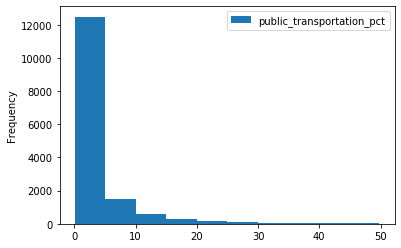

In [12]:
data = pd.read_sql_query("""
    SELECT *
    FROM public_transportation_by_zip 
    WHERE public_transportation_pct > 0 
    AND public_transportation_pct < 50""", engine)
data.plot.hist(y='public_transportation_pct')

## 6.	Using pandas, test using the to_sql function with and without the method=psql_insert_copy parameter. How does the speed compare?

In [13]:
import csv
from io import StringIO

from sqlalchemy import create_engine

def psql_insert_copy(table, conn, keys, data_iter):
    # gets a DBAPI connection that can provide a cursor
    dbapi_conn = conn.connection
    with dbapi_conn.cursor() as cur:
        s_buf = StringIO()
        writer = csv.writer(s_buf)
        writer.writerows(data_iter)
        s_buf.seek(0)

        columns = ', '.join('"{}"'.format(k) for k in keys)
        if table.schema:
            table_name = '{}.{}'.format(table.schema, table.name)
        else:
            table_name = table.name

        sql = 'COPY {} ({}) FROM STDIN WITH CSV'.format(
            table_name, columns)
        cur.copy_expert(sql=sql, file=s_buf)

In [14]:
%time data.to_sql('public_transportation_by_zip', engine, method=psql_insert_copy, if_exists='replace')

CPU times: user 45.9 ms, sys: 4.56 ms, total: 50.4 ms
Wall time: 148 ms


In [15]:
%time data.to_sql('public_transportation_by_zip', engine, if_exists='replace')

CPU times: user 655 ms, sys: 380 ms, total: 1.04 s
Wall time: 2.69 s


## 7.	Group customers based on their zipcode public transportation usage, rounded to the nearest 10% and look at the average number of transactions per customer. Export this data to excel and create a scatterplot to better understand the relationship between public transportation usage and sales. 

In [16]:
data = pd.read_sql_query("""
    SELECT
        10 * ROUND(public_transportation_pct/10) AS public_transport,
        COUNT(s.customer_id) * 1.0 / COUNT(DISTINCT c.customer_id) AS sales_per_customer 
    FROM customers c
    INNER JOIN public_transportation_by_zip t ON t.zip_code = c.postal_code
LEFT JOIN sales s ON s.customer_id = c.customer_id
WHERE public_transportation_pct >= 0
GROUP BY 1
""", engine)

In [17]:
data.to_csv('sales_vs_public_transport_pct.csv')

\copy (SELECT * FROM public_transport_statistics) TO 'pub-lic_transport_distribution.csv' CSV HEADER;